# Model development
We are using mgcv::gam library and a mixed-effects modeling approach.

In [1]:
suppressMessages({
    library(dplyr)
    library(ggrepel)
    library(ggpmisc)
    library(ggprism)
    library(tidyverse)
    library(caret)
    library(gamm4)
    library(gtools)
    library(coefplot)
    library(effectsize)
    library(AICcmodavg)
    library(ggpubr)
    library(patchwork)
    library(emmeans)
    library(jtools)
    library(mgcViz)
    library(ggbreak)
    library(ggpattern)
    library(scales)
    library(doParallel)
})

# parallel registration
cl <- makePSOCKcluster(detectCores() - 1)
registerDoParallel(cl)

agd_palette <- c("#0063C3", "#00BCD0", "#CB7C85",  "#E8C9BB", "#252A5A", 
                  "#7D2C42", "#A9A9A9")

## Data and Features

In [2]:
# original data
dat_1 <- read.csv("../data/fluorination_train.csv", stringsAsFactors = T)
dat_2 <- read.csv("../data/fluorination_test.csv", stringsAsFactors = T)

dat <- rbind(dat_1, dat_2)
dat <- dat %>%
        rename(s = sulfonyl.fluoride, a = alcohol, b = base) %>%
        mutate(s = sub("\\.", "-", s)) %>%
        mutate(s = gsub("3-", "4-", s)) %>%
        mutate(s = factor(s))

# reactions data
rxns <- dat %>% select(a, b, s, yield)

In [3]:
# pre-process factor like features from the original publication
da_orig <- dat %>% select("a", contains("alcohol")) %>% distinct()

da_fact <- da_orig %>%
    select("a", where(is.integer)) %>%
    rename_with(~ sub("alcohol_", "", .x)) %>%
    rename_with(~ sub("\\.", "_", .x))

# coalesce one-hot spread features that's not needed and only takes space
order <- da_fact %>%
    select(primary, secondary, tertiary) %>%
    mutate_all(as.character) %>%
    mutate(secondary = recode(secondary, "1" = "2"),
           tertiary = recode(tertiary, "1" = "3")) %>%
    mutate(order = pmax(primary, secondary, tertiary)) %>%
    mutate(order = recode(order, "1" = "primary",
                                 "2" = "secondary",
                                 "3" = "tertiary")) %>%
    pull(order)

ring_size <- da_fact %>%
    select(`4_membered_ring`, `5_membered_ring`,
            `6_membered_ring`, `7_membered_ring`) %>%
    mutate_all(as.character) %>%
    mutate(r4 = recode(`4_membered_ring`, "1" = "4", "0" = "NA"),
           r5 = recode(`5_membered_ring`, "1" = "5", "0" = "NA"),
           r6 = recode(`6_membered_ring`, "1" = "6", "0" = "NA"),
           r7 = recode(`7_membered_ring`, "1" = "7", "0" = "NA")) %>%
    mutate(ring_size = pmin(r4, r5, r6, r7)) %>%
    mutate(ring_size = recode(ring_size, "NA" = "0")) %>%
    pull(ring_size)

da_fact <- da_fact %>%
    mutate(ring_size = ring_size, order = order) %>%
    select(-contains("membered_ring")) %>%
    select(-primary, -secondary, -tertiary, -cyclic) %>%
    mutate_all(as.factor)

In [4]:
# read alcohol DFT features
glb_feats <- c("number_of_atoms", "molar_mass", "electronegativity",
               "electronic_spatial_extent", "hardness", "homo_energy",
               "lumo_energy", "molar_volume", "dipole", 
               "OC_length", "OC_L", "OC_B1", "OC_B5")
c_feats <- c("C_APT_charge", "C_Mulliken_charge", "C_NMR_shift",
           "C_NPA_charge", "C_VBur", "C_angle", "C_PVBur")
o_feats <- c("O_APT_charge", "O_Mulliken_charge", "O_NMR_shift",
            "O_NPA_charge", "O_VBur")

# M062X calculation
da_dft_m062x <- read.csv("../data/alcohols_Boltzmann_M062X_THF.csv") %>%
    select(-inchi) %>%
    rename(a = name) %>%
    select("a", all_of(glb_feats), all_of(c_feats), all_of(o_feats))

da_dft <- da_dft_m062x
da <- merge(da_dft, da_fact)

In [5]:
# helper functions
normalize_yield <- function(yield) {
    y <- ifelse(yield > 97, 100 - runif(n(), 0.1, 3),
        ifelse(yield < 3, runif(n(), 0.1, 3), yield)) / 100
    return(y)
}

In [6]:
# build final dataframe for analysis
data <- rxns %>%
    mutate(prob = normalize_yield(yield)) %>%
    left_join(da, by = "a") %>%
    mutate(a = as.factor(a))

## ANOVA
This is where we start analyzing the experiment, i.e., we need to find the appropriate interaction model, followed by inference about the effects.

In [7]:
# fit of the fixed effects model - M0
fam <- gaussian()
m <- mgcv::gam(
    formula = prob ~ a + b + s + a:b + a:s + b:s,
    data = data,
    family = gaussian())
# anova table
mgcv::anova.gam(m)


Family: gaussian 
Link function: identity 

Formula:
prob ~ a + b + s + a:b + a:s + b:s

Parametric Terms:
     df      F  p-value
a    36 80.634  < 2e-16
b     3  5.734 0.000745
s     4  5.184 0.000436
a:b 108 18.687  < 2e-16
a:s 144 23.132  < 2e-16
b:s  12  3.597 3.87e-05


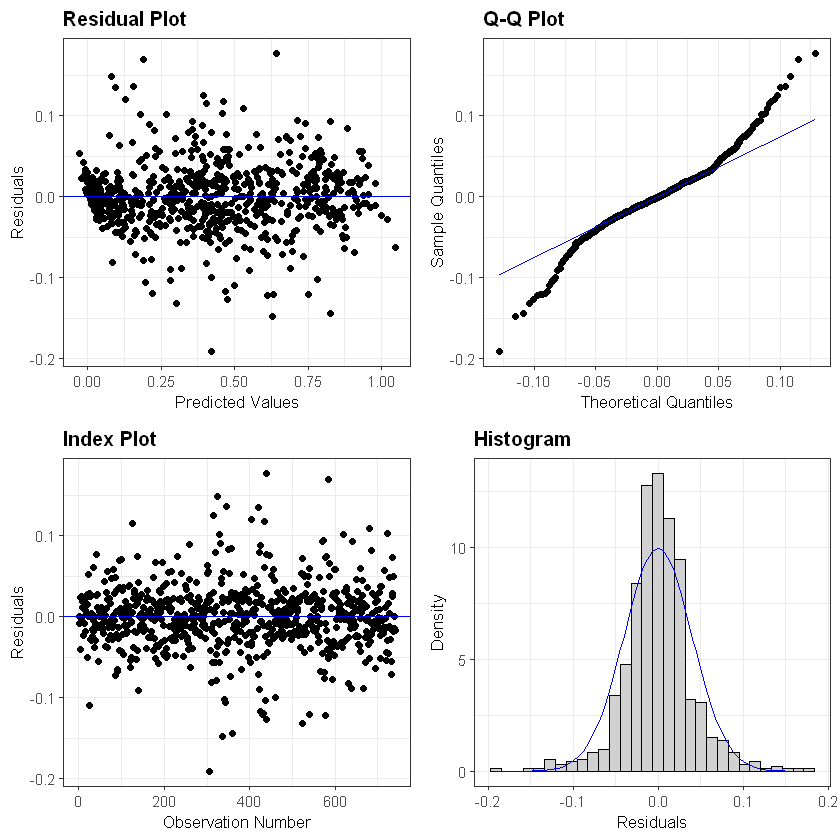

In [8]:
ggResidpanel::resid_auxpanel(residuals = m$residuals,
                             predicted = m$fitted.values)

In [9]:
# compute eta-squared
d <- eta_squared(aov(m), ci = 0.95) %>%
    as.data.frame() %>%
    mutate(Parameter = factor(Parameter,
           levels = c("b:s", "a:s", "a:b", "s", "b", "a")))

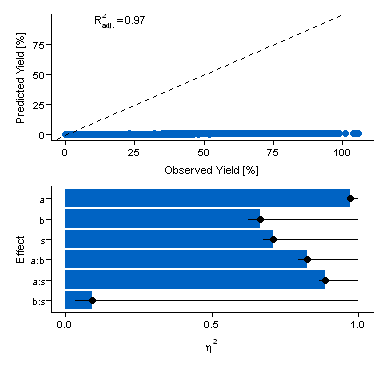

In [10]:
# fixed effects model plot for the paper
p1 <- data %>%
    select(prob, yield) %>%
    mutate(pred = predict(m, type = "response")) %>%
ggplot(aes(x = yield, y = pred)) +
      geom_point(color = agd_palette[1]) +
      geom_abline(aes(intercept = 0, slope = 1), linetype = 2) +
      annotate("text", label = "R[adj.]^2== 0.97", x = 20, y = 95,
                parse = T, size = 6.3 / .pt) +
      labs(y = "Predicted Yield [%]",
           x = "Observed Yield [%]") +
      theme_prism(base_size = 6.3) +
      theme(text = element_text(face = "plain", family = "sans"))

p2 <- ggplot(d, aes(x = Parameter, y = Eta2_partial,
                    ymin = CI_low, ymax = CI_high)) +
      geom_bar(stat = "identity", alpha = 1., fill = agd_palette[1]) +
      geom_point() +
      geom_errorbar(width = 0) +
      scale_y_continuous(breaks = scales::breaks_pretty(3)) +
      labs(x = "Effect", y = expression(eta^2)) +
      theme_prism(base_size = 6.3) + coord_flip() +
      theme(text = element_text(face = "plain", family = "sans"))

options(repr.plot.width = 3.24, repr.plot.height = 3.08)
p1 / p2

ggsave("../doexyF_paper/plots/anova.svg", width = 3.24, height = 3.08)
ggsave("../doexyF_paper/plots/anova.png", width = 3.24, height = 3.08,
 dpi = 600)

In [11]:
# save fixed effects model plots for paper
ggsave("../doexyF_paper/plots/anova_A.svg", p1, width = 3.24, height = 3.08 / 2)
ggsave("../doexyF_paper/plots/anova_A.png", p1, width = 3.24, height = 3.08 / 2,
 dpi = 600)
ggsave("../doexyF_paper/plots/anova_B.svg", p2, width = 3.24, height = 3.08 / 2)
ggsave("../doexyF_paper/plots/anova_B.png", p2, width = 3.24, height = 3.08 / 2,
 dpi = 600)

## Analysis of Interactions
Obtain interaction values using trt.vs.ctrl contrast and plot them against tentative features.

In [12]:
# compute interaction effects with trt.vs.ctrl contrast
ab <- emmeans(m, trt.vs.ctrl ~ b | a, ref = "BTPP")
as <- emmeans(m, trt.vs.ctrl ~ s | a, ref = "PBSF")

ab_ctr <- as.data.frame(ab$contrast) %>%
    mutate(contrast = as.factor(gsub(" - BTPP", "", contrast)))

ab_eff <- as.data.frame(ab$emmeans)

as_ctr <- as.data.frame(as$contrast) %>%
    mutate(contrast = gsub("\\(", "",
                      gsub("\\)", "",
                      gsub(" - PBSF", "", contrast)))) %>%
    mutate(contrast = as.factor(contrast))

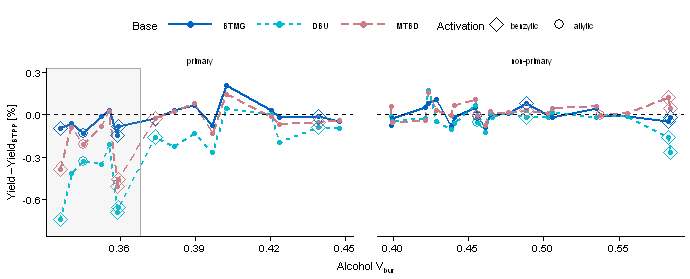

In [13]:
# alcohol - base interaction plot for paper
options(repr.plot.height = 2.33, repr.plot.width = 5.75)
plot_data <- ab_ctr %>%
    left_join(da, by = "a") %>%
    mutate(isprimary = factor(ifelse(order == "primary",
                                              "primary", "non-primary"),
           levels = c("primary", "non-primary"))) %>%
    mutate(a = as.factor(gsub("1", "", a))) %>%
    mutate(a = fct_reorder(a, C_PVBur)) %>%
    mutate(activation = factor(ifelse(allylic == 1, "allylic",
    ifelse(benzylic == 1, "benzylic", "unactivated")),
          levels = c("unactivated", "benzylic", "allylic")))

p3 <- ggplot(plot_data,
           aes(x = C_PVBur, y = estimate, ymax = (estimate + 2 * SE),
           ymin = (estimate - 2 * SE), color = contrast)) +
     geom_line(aes(linetype = contrast), alpha = 1, size = 0.6) +
     geom_hline(yintercept = 0, linetype = 2) +

     geom_point(size = 1) +
     geom_point(data = plot_data %>%
          filter(activation %in% c("benzylic", "allylic")),
                 aes(shape = activation, size = activation)) +
     geom_rect(data = data.frame(isprimary = factor("primary"), C_PVBur = 0.36,
          estimate = 0, SE = 0),
          xmin = -Inf, xmax = 0.368,
          ymin = -Inf, ymax = Inf, alpha = 0.1,
          fill = agd_palette[7], color = agd_palette[7]) +

     facet_wrap(. ~ isprimary, ncol = 2, scales = "free_x") +

     theme_prism(base_size = 6.3) +

     scale_color_manual(values = agd_palette) +
     scale_size_manual(values = c(2.5, 2.5)) +
     scale_shape_manual(values = c(5, 1)) +

     labs(x = expression(paste("Alcohol", " ", V[bur])),
          y = expression(paste(Yield - Yield[BTPP], " [%]")),
          color = "Base", linetype = "Base",
          size = "Activation",
          shape = "Activation") +

     theme(legend.position = "top", legend.title = element_text()) +
     theme(panel.spacing = unit(1, "line")) +
     theme(text = element_text(face = "plain", family = "sans")) +
     guides(color = guide_legend(keywidth = unit(2.3, "line")))

p3

ggsave("../doexyF_paper/plots/interactions_A.svg",
 p3, width = 5.75, height = 2.33)
ggsave("../doexyF_paper/plots/interactions_A.png",
 p3, width = 5.75, height = 2.33, dpi = 600)

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



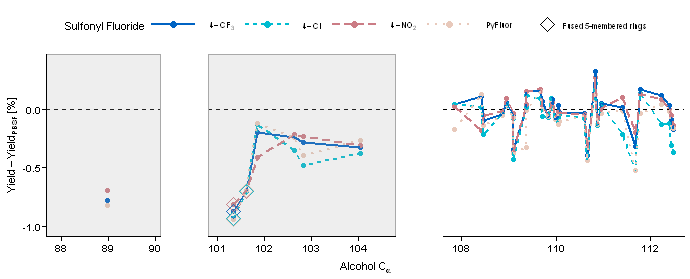

In [14]:
# alcohol-sulfonul fluoride interaction plot for paper

options(repr.plot.height = 2.33, repr.plot.width = 5.75)
plot_data <- as_ctr %>%
    left_join(da, by = "a") %>%
    mutate(ring_angle = ifelse(C_angle < 90, "0", 
                               ifelse(C_angle < 105, "1", "2"))) %>%
    mutate(a = as.factor(gsub("1", "", a))) %>%
    mutate(a = fct_reorder(a, C_angle)) %>%
    mutate(Cupped = if_else(C_angle < 101.75 & ring_size == 5,
                            "Fused 5-membered rings", "Other")) %>%
    mutate(contrast = factor(contrast, labels = expression(4-CF[3], 4-Cl, 4-NO[2], PyFluor)))

p4 <- ggplot(plot_data,
           aes(x = C_angle, y = estimate, ymax = (estimate + 2 * SE),
           ymin = (estimate - 2 * SE), color = contrast)) +

    geom_point(size = 1) +
    geom_hline(yintercept = 0, linetype = 2) +
    geom_line(aes(
                  linetype = contrast),
                  alpha = 1, size = 0.6) +
    geom_point(data = plot_data %>% filter(Cupped == "Fused 5-membered rings"),
               aes(shape = Cupped, size = Cupped)) +
    geom_rect(data = data.frame(ring_angle = c("0", "0", "1", "1"),
                                estimate = 0,
                                C_angle = c(87.8, 90, 101, 104.6)),
                xmin = -Inf, xmax = Inf,
                ymin = -Inf, ymax = Inf, alpha = 0.1,
                fill = agd_palette[7],
                color = agd_palette[7]) +

    facet_grid(. ~ ring_angle, scales = "free_x", space = "free") +
    theme_prism(base_size = 6.3) +

    scale_color_manual(values = agd_palette,
                       labels = parse_format()) +
    scale_linetype_manual(values = c(linetype_pal()(3), "dotted"),
                          labels = parse_format()) +
    scale_x_continuous(breaks = scales::pretty_breaks(n = 3),
                       position = "bottom") +
    scale_size_manual(values = c(2.5)) +
    scale_shape_manual(values = c(5)) +

    theme(legend.position = "top", legend.title = element_text()) +
    theme(panel.spacing = unit(2, "lines")) +
    theme(strip.background = element_blank(),  strip.text.x = element_blank()) +
    theme(text = element_text(face = "plain", family = "sans")) +
    labs(x = expression(paste("Alcohol", " ", C[alpha])),
         y = expression(paste(Yield - Yield[PBSF], " [%]")),
         color = "Sulfonyl Fluoride",
         linetype = "Sulfonyl Fluoride", size = "", shape = "") +
    guides(color = guide_legend(keywidth = unit(2.3, "line")))

p4

ggsave("../doexyF_paper/plots/interactions_B.svg",
 p4, width = 5.75, height = 2.33)
ggsave("../doexyF_paper/plots/interactions_B.png",
 p4, width = 5.75, height = 2.33, dpi = 600)

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



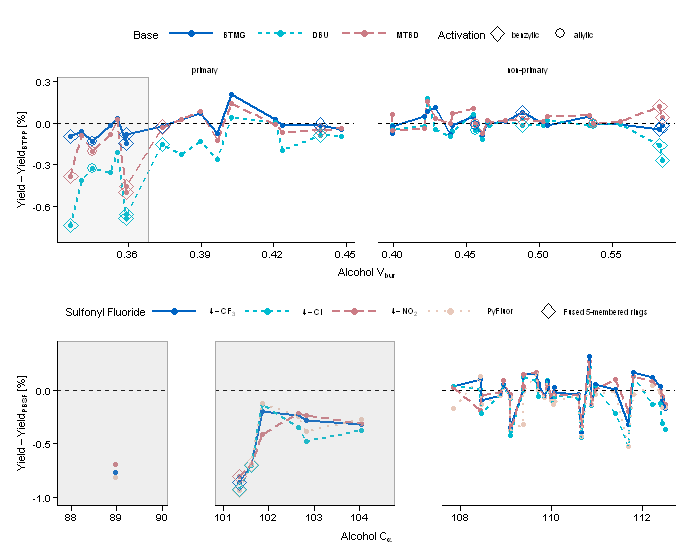

In [15]:
# Save interaction plots for paper
options(repr.plot.width = 5.75, repr.plot.height = 4.66)
p3 / p4 + plot_layout(heights = c(1, 1))

ggsave("../doexyF_paper/plots/interactions.svg",
 width = 5.75, height = 4.66)
ggsave("../doexyF_paper/plots/interactions.png",
 width = 5.75, height = 4.66, dpi = 600)

## Analysis of the Main Effect
Obtain the values of the effect from the model itself. Analyze the random effect that's attributed to alcohol.

In [16]:
# Compute the alcohol effect at BTPP/PBSF level
aeff <- as.data.frame(emmeans(m, ~ a | b * s)) %>%
     filter(b == "BTPP", s == "PBSF") %>%
     left_join(da, by = "a")

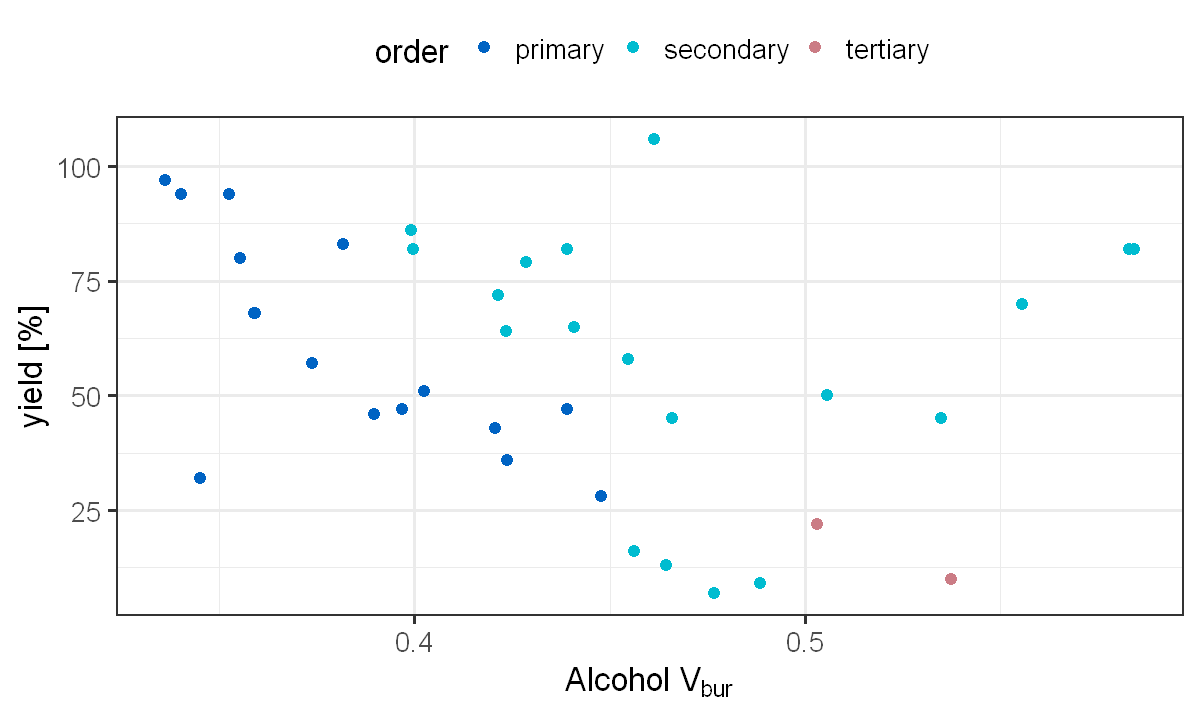

In [38]:
options(repr.plot.width=10, repr.plot.height=6)
data %>% filter(b == 'BTPP', s == 'PBSF') %>%
ggplot(aes(x=C_PVBur, y = yield, color = order)) +
geom_point(size=3) +
scale_color_manual(values = agd_palette) +
labs(x = expression(paste("Alcohol ", V[bur])), y = "yield [%]") +
theme_bw(base_size = 20) +
theme(legend.position = 'top')

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



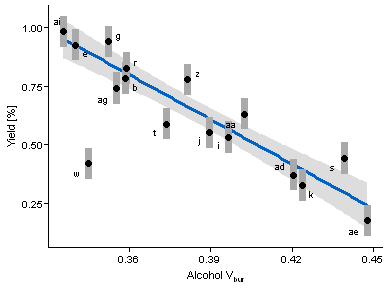

In [17]:
# Plot main effect dependence for primary alcohols
options(repr.plot.height = 2.4, repr.plot.width = 3.24)

aeff_p <- aeff %>% filter(order == "primary")
aeff_s <- aeff %>% filter(order == "secondary")

p1 <- ggplot(aeff_p,
       aes(y = emmean, ymax = upper.CL, ymin = lower.CL,
           x = C_PVBur)) +

    geom_smooth(data = aeff_p %>% filter(a != "1w"),
                method = "lm", color = agd_palette[1], fill = agd_palette[7]) +
    geom_errorbar(width = 0, alpha = 1, size = 2, color = agd_palette[7]) +
    geom_point() +
    geom_text_repel(aes(label = gsub("1", "", a)), size = 2) +

    theme_prism(base_size = 6.3) +

    labs(x = expression(paste("Alcohol", " ", V[bur])), y = "Yield [%]") +
    scale_color_manual(values = agd_palette) +
    scale_fill_manual(values = agd_palette) +
    theme(legend.position = "top") +
    theme(text = element_text(face = "plain", family = "sans"))

p1

ggsave("../doexyF_paper/plots/main_eff_A.svg", p1,
 width = 3.24, height = 2.4)
ggsave("../doexyF_paper/plots/main_eff_A.png", p1,
 width = 3.24, height = 2.4, dpi = 600)

In [22]:
# make features for fitting the final model

model_features <- function(data) {
    data %>%
    mutate(isPBSF = as.factor(s == "PBSF"),
           exposed = as.factor(C_PVBur < 0.37),
           ring_size_4 = as.factor(ring_size == 4),
           ring_size_5 = as.factor(ring_size == 5),
           strained = as.factor(C_angle < 101.75),
           primary = as.integer(order == "primary"),
           tertiary = as.factor(order == "tertiary"))
}

data_m <- model_features(data)

In [23]:
# fit an intermittent model with a random effect for alcohol and all
# effects already in play
m_int <- gam(yield ~
    + b + s
    + b:(exposed + exposed:benzylic)
    + (strained:ring_size_5 + tertiary):isPBSF
    + s(a, bs = "re")
    + allylic
    + homoallylic
    + I(C_PVBur * primary) + primary
    , data = data_m, method = "REML", family = gaussian())

round(summary(m_int)$r.sq, 2)

[1] 0.88

In [24]:
# fetch the terms that correspond to the random alcohol effect
p <- predict(m_int, type = "terms", se.fit = TRUE)
re2 <- p[["fit"]][, "s(a)"]
se2 <- p[["se.fit"]][, "s(a)"]

aeff <- data.frame(eff = re2, se = se2, a = data_m$a) %>%
    distinct() %>%
    left_join(da, by = "a")

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'



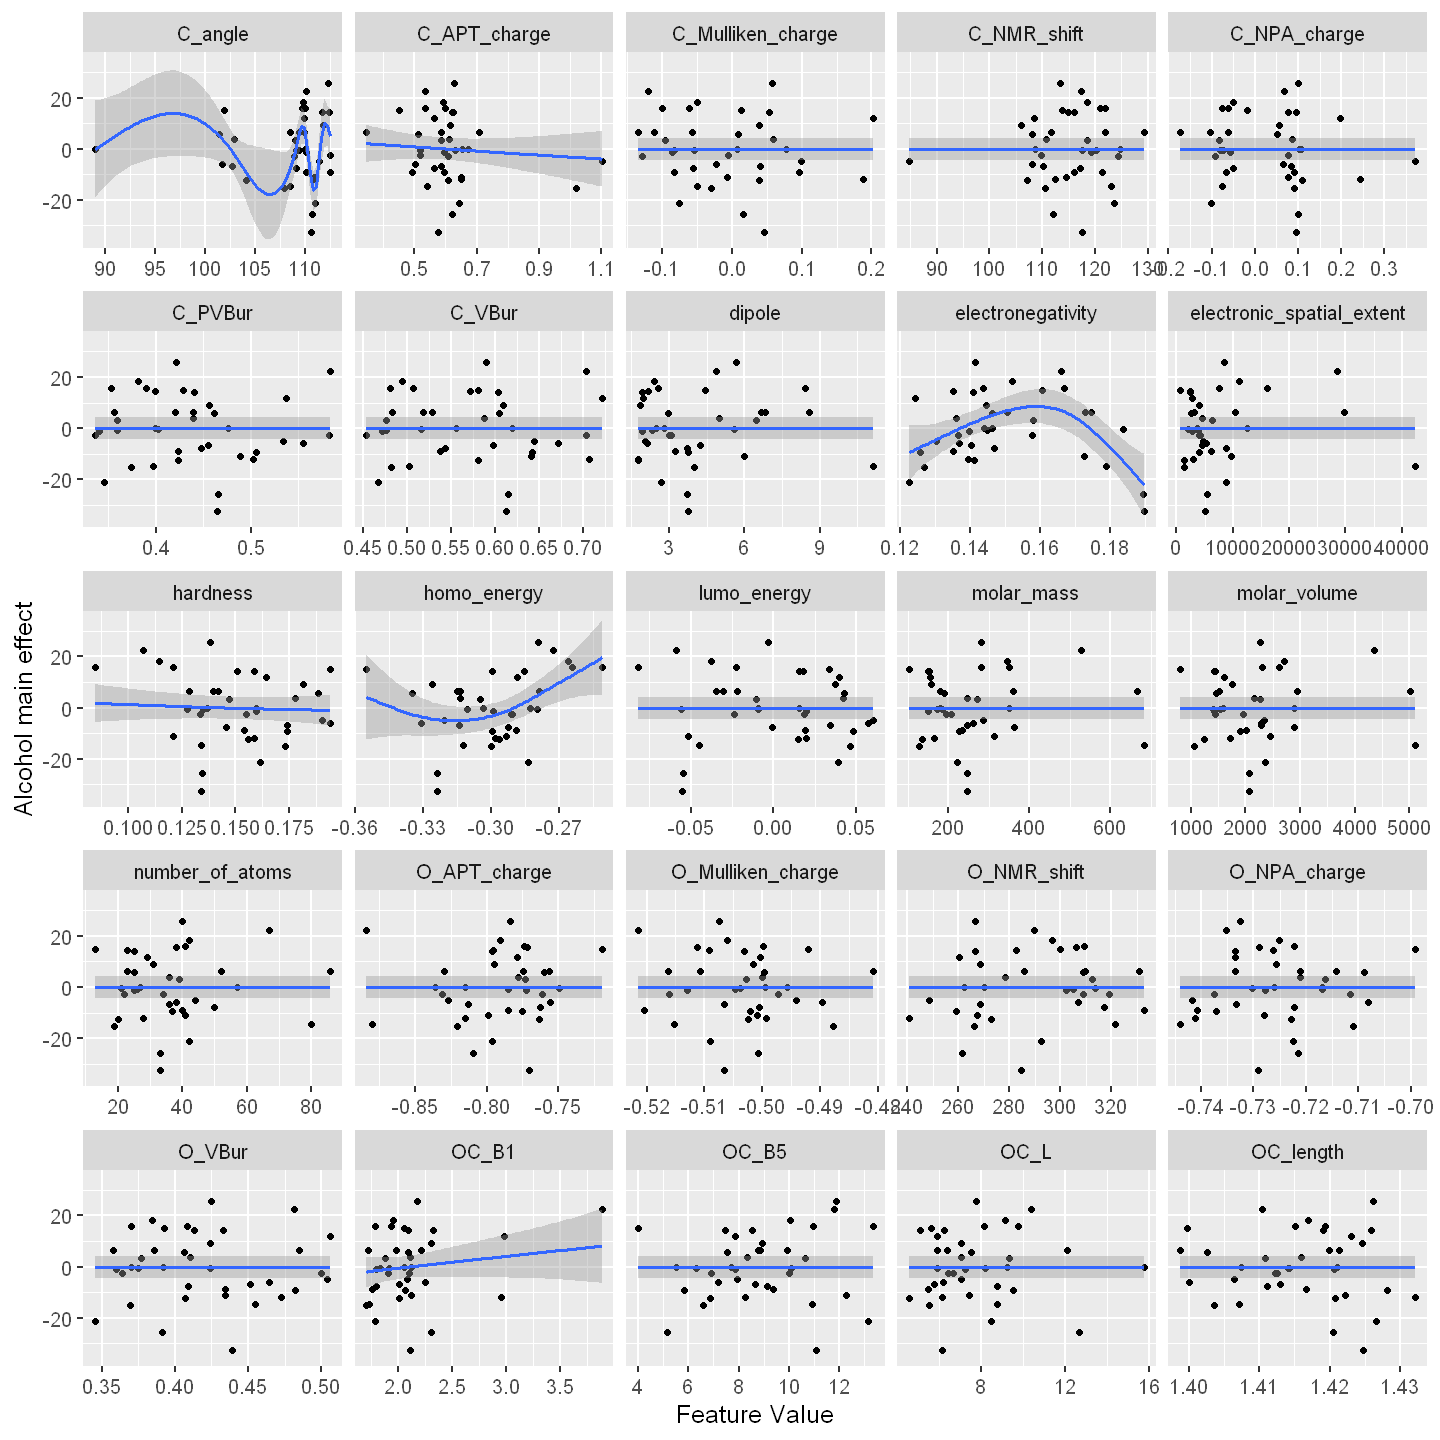

In [144]:
options(repr.plot.width=12, repr.plot.height=12)
aeff %>% 
    column_to_rownames('a') %>%
    select_if(is.numeric) %>%
    dplyr::select(-se) %>%
    pivot_longer(cols = colnames(da_dft %>% dplyr::select(-a))) %>%
    ggplot(aes(x = value, y = eff)) +
    geom_point() +
    geom_smooth(method = "gam") + 
    labs(x = "Feature Value", y = "Alcohol main effect") +
    facet_wrap(. ~ name, scales = 'free_x') +
    theme_grey(base_size = 15)

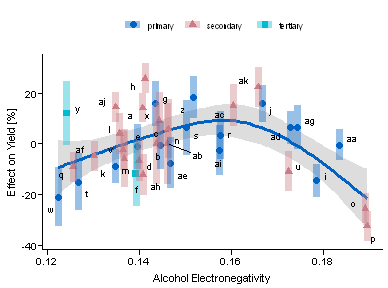

In [25]:
# make the alcohol effect plot for the paper
options(repr.plot.height = 2.4, repr.plot.width = 3.24)

p2 <- ggplot(aeff, aes(y = eff, ymax = eff + se, ymin = eff - se,
                 x = electronegativity)) +
    geom_smooth(method = "gam", color = agd_palette[1], fill = agd_palette[7],
               formula = y ~ s(x, bs = "cs", k = 5)) +
    geom_point(aes(color = order, shape = order)) +
    geom_errorbar(aes(color = order), width = 0, size = 2, alpha = 0.4) +
    geom_text_repel(aes(label = gsub("1", "", a)), size = 2) +
    labs(y = "Effect on Yield [%]", x = "Alcohol Electronegativity") +
    scale_color_manual(values = agd_palette[c(1, 3, 2)]) +
    scale_fill_manual(values = agd_palette[c(1, 3, 2)]) +
    theme_prism(base_size = 6.3) +
    theme(text = element_text(face = "plain", family = "sans")) +
    theme(legend.position = "top")
    
p2

ggsave("../doexyF_paper/plots/main_eff_B.svg", p2,
 width = 3.24, height = 2.4)
ggsave("../doexyF_paper/plots/main_eff_B.png", p2,
 width = 3.24, height = 2.4, dpi = 600)

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



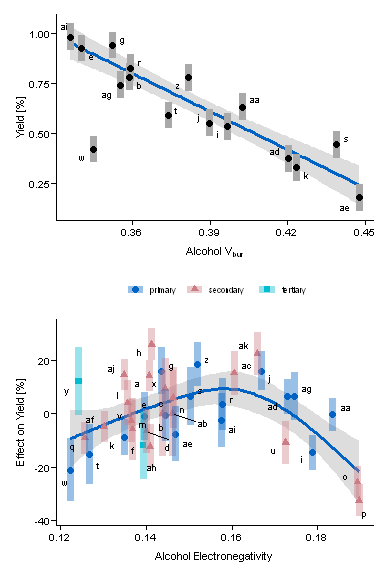

In [26]:
# save the alcohol main effect for the paper
options(repr.plot.width = 3.24, repr.plot.height = 4.8)
p1 / p2

ggsave("../doexyF_paper/plots/main_eff.svg",
 width = 3.24, height = 4.8)
ggsave("../doexyF_paper/plots/main_eff.png",
 width = 3.24, height = 4.8, dpi = 600)


## Build Final $M_{1}$ model
Fit the model, and save its training predictions.

In [109]:
# fit the final model
ma <- mgcv::gam(prob ~
    + b + s  + b:(exposed + exposed:benzylic)
    + (strained:ring_size_5 + tertiary):isPBSF
    + allylic + homoallylic
    + I(C_PVBur * primary) + primary
    + s(electronegativity, k = 4)
    , data = data_m, method = "REML", family = gaussian())

# ANOVA table
mgcv::anova.gam(ma)


Family: gaussian 
Link function: identity 

Formula:
prob ~ +b + s + b:(exposed + exposed:benzylic) + (strained:ring_size_5 + 
    tertiary):isPBSF + allylic + homoallylic + I(C_PVBur * primary) + 
    primary + s(electronegativity, k = 4)

Parametric Terms:
                            df       F  p-value
b                            3   5.391  0.00113
s                            4  28.958  < 2e-16
allylic                      1 116.912  < 2e-16
homoallylic                  1 257.285  < 2e-16
I(C_PVBur * primary)         1 308.741  < 2e-16
primary                      1 288.768  < 2e-16
b:exposed                    4  13.656 9.92e-11
tertiary:isPBSF              2  52.441  < 2e-16
b:exposed:benzylic           8  22.193  < 2e-16
isPBSF:strained:ring_size_5  6  86.434  < 2e-16

Approximate significance of smooth terms:
                       edf Ref.df     F p-value
s(electronegativity) 2.979  3.000 148.8  <2e-16

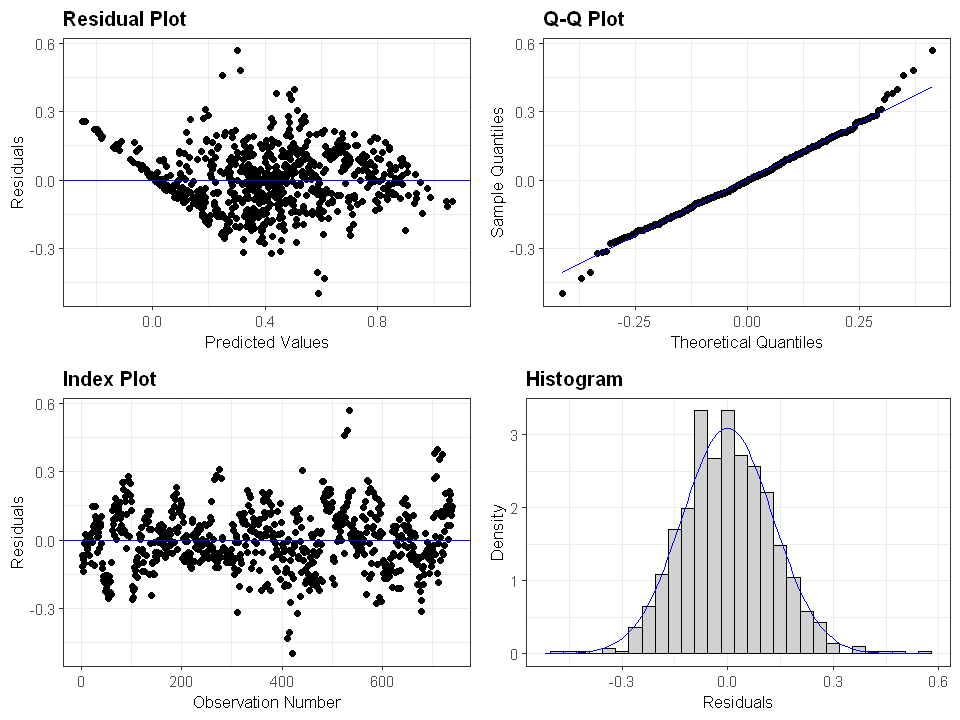

In [120]:
suppressWarnings(
ggResidpanel::resid_auxpanel(residuals = ma$residuals,
                             predicted = ma$fitted.values))

In [30]:
# make predictions on the training data (for training error)
data_plot <- data %>%
    mutate(pred.traingam = pmax(0, predict(ma, type = "response")))

## Validations
First leave one alcohol out

In [31]:
# leave-one-molecule out indexing
index <- seq_along(data_m$yield)
index_out <- split(index, data_m$a)
index_in <- lapply(index_out, function(i) setdiff(index, i))

Add baseline models

In [32]:
ctrl <- trainControl(method="LGOCV", number = length(index_in),
                     index = index_in, indexOut = index_out, selectionFunction = 'best',
                     savePredictions = "final")

In [39]:
mltools::one_hot(X.fact) #%>% head()

ERROR: Error in `[.data.frame`(dt, , cols, with = FALSE): unused argument (with = FALSE)


In [40]:
######### REVISION WORK CELL #########
# some preprocessing of X, y data

y <- data$prob
X <- data %>% dplyr::select(-a, -yield, -prob, -C_VBur)

X.num <- X %>% dplyr::select_if(is.numeric)
X.fact <- X %>% dplyr::select_if(is.factor)

#X.fact.onehot <- mltools::one_hot(X.fact)
X.fact.dummy <- fastDummies::dummy_cols(X.fact, remove_selected_columns = T, remove_first_dummy = T)

#X.onehot <- cbind(X.fact.onehot, X.num)
X.dummy <- cbind(X.fact.dummy, X.num)

In [41]:
# dummy model
mb0 <- train(prob ~ b * s, data = data, method = "lm", trControl = ctrl)
# RF model
mb1 <- train(X.dummy, y, method = "rf", ntree = 100, trControl = ctrl, importance = TRUE,
           tuneGrid = expand.grid(mtry = c(1, 2, 3, 5, 7, 10, 15)))

In [42]:
# lasso model
mb2 <- train(X.dummy, y, trControl = ctrl, method = 'glmnet',
    preProcess = c('center', 'scale'),
    tuneGrid = expand.grid(alpha = 1, lambda = c(0.001, 0.003, 0.006, 0.01, 0.015, 0.02, 0.03)))

In [43]:
# forward linear regression
mb3 <- train(X.dummy, y, trControl = ctrl, method = 'leapForward',
    preProcess = c('center', 'scale'),
    tuneGrid = expand.grid(nvmax = c(2, 3, 4, 5, 6, 7, 8, 9, 10))
    )

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."
Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"


Reordering variables and trying again:


Warning message:
"Ignoring unknown parameters: coor"
Warning message:
"Ignoring unknown parameters: coor"
Warning message:
"Ignoring unknown parameters: coor"
Warning message:
"Removed 1 rows containing missing values (geom_point)."
Warning message:
"Removed 1 row(s) containing missing values (geom_path)."


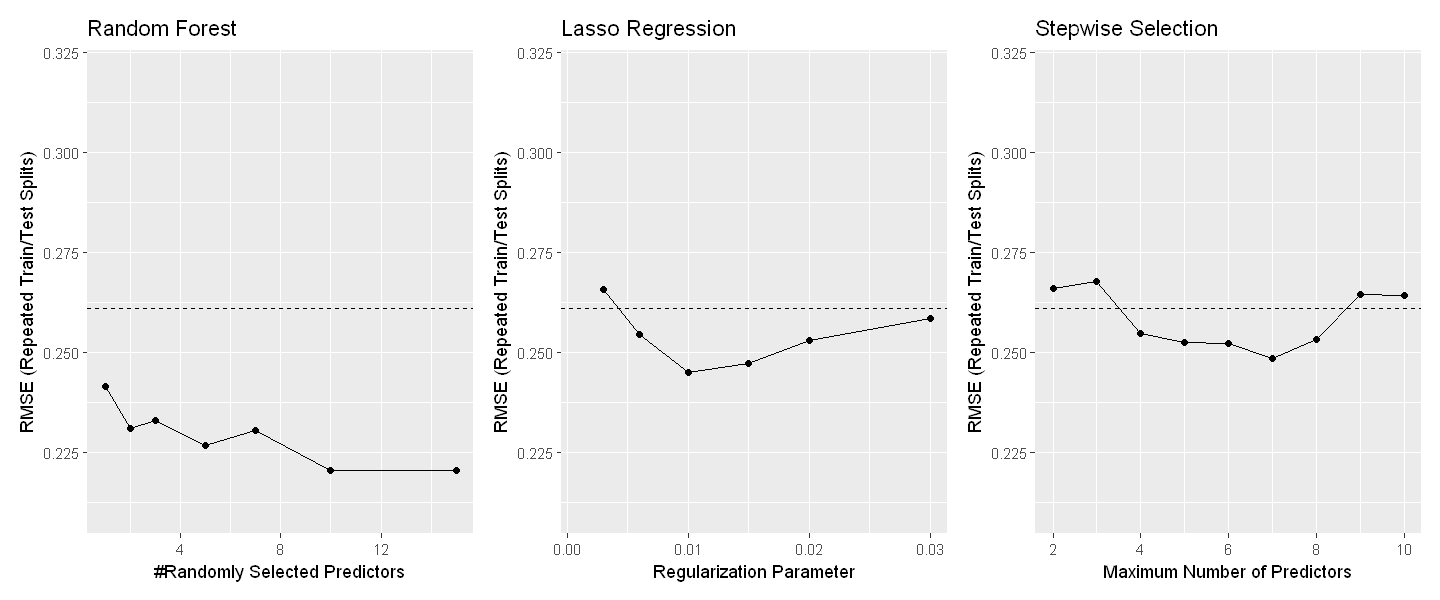

In [44]:
options(repr.plot.width = 12, repr.plot.height = 5) 
p1 <- ggplot(mb1)  + geom_hline(yintercept=mb0$results$RMSE, coor='red', linetype=2) + labs(title="Random Forest") + ylim(c(0.21, 0.32))
p2 <- ggplot(mb2)  + geom_hline(yintercept=mb0$results$RMSE, coor='red', linetype=2) + labs(title="Lasso Regression") + ylim(c(0.21, 0.32))
p3 <- ggplot(mb3)  + geom_hline(yintercept=mb0$results$RMSE, coor='red', linetype=2) + labs(title="Stepwise Selection") + ylim(c(0.21, 0.32))

(p1 + p2 + p3)

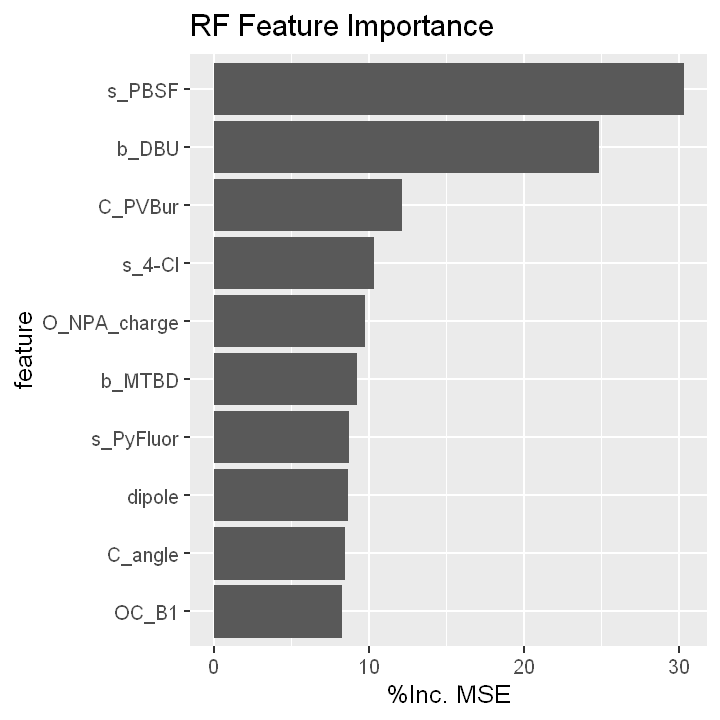

In [45]:
options(repr.plot.width = 6, repr.plot.height = 6) 
# rf feature importance
randomForest::importance(mb1$finalModel, type=1, n.var=10) %>% as.data.frame() %>% 
    rownames_to_column("feature") %>% rename(imp = "%IncMSE") %>% arrange(-imp) %>% head(10) %>%
ggplot(aes(y=reorder(feature, imp), x = imp)) +
geom_bar(stat='identity') +
labs(x = "%Inc. MSE", y = 'feature', title='RF Feature Importance') +
theme_gray(base_size = 15)

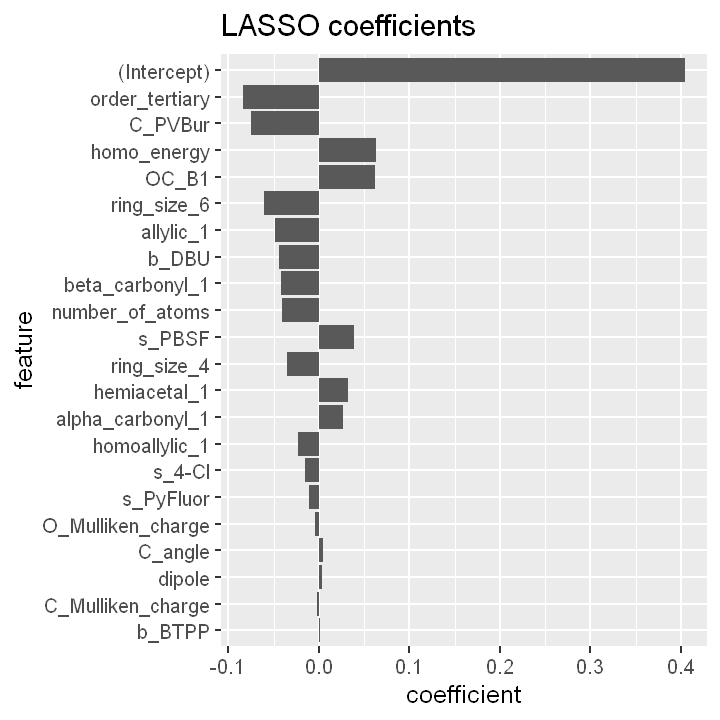

In [46]:
# lasso coefficients
cf1 <- coef(mb2$finalModel, s = mb2$bestTune$lambda) %>% as.matrix %>% as.data.frame() %>% rownames_to_column("feature")
cf1 %>% filter(s1 != 0) %>% arrange(-abs(s1)) %>%
ggplot(aes(y=reorder(feature, abs(s1)), x=s1)) +
labs(x = 'coefficient', y='feature', title = 'LASSO coefficients') +
geom_bar(stat='identity') + theme(legend.position = 'none') +
theme_gray(base_size = 15)

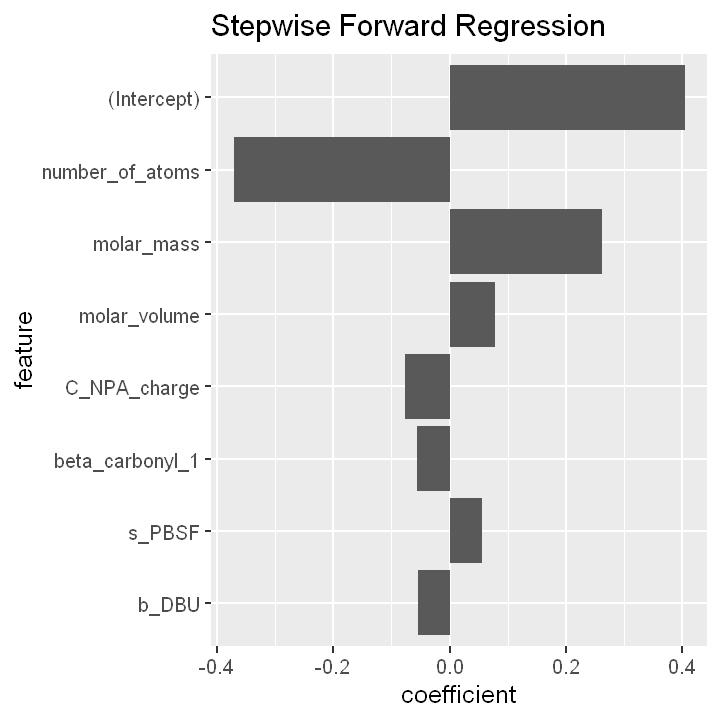

In [47]:
coef(mb3$finalModel, 7) %>% as.data.frame() %>% rename(s1 = ".") %>% rownames_to_column("feature") %>%
ggplot(aes(reorder(feature, abs(s1)), x=s1)) + 
labs(x = 'coefficient', y = 'feature', title = "Stepwise Forward Regression") +
geom_bar(stat='identity') + theme(legend.position = 'none') +
theme_gray(base_size = 15)

In [48]:
data_plot <- data_plot %>% mutate(pred.trainrf = predict(mb1))

$M_1$ model

In [49]:
fam <- gaussian()
frml <- ma$formula
frml

prob ~ +b + s + b:(exposed + exposed:benzylic) + (strained:ring_size_5 + 
    tertiary):isPBSF + allylic + homoallylic + I(C_PVBur * primary) + 
    primary + s(electronegativity, k = 4)

In [50]:
# parallel loop
pred <- foreach(iout = index_out,
                .packages = c("mgcv", "randomForest", "dplyr")) %dopar% {

    tr <- data_m[-iout, ]
    tst <- data_m[iout, ]


    nha <- length(unique(tr[-iout, "homoallylic"]))
    if (nha == 2) {
        frml_i <- frml
    } else {
        frml_i <- update(frml, ~. - homoallylic)
    }

    mi <- gam(frml_i, data = tr, method = "REML", select = F, family = fam)
    mrfi <- randomForest(tr %>% select(-a, -yield, -prob),
                         tr$prob, ntree = 100, mtry = 5)
    pi <- predict(mi, newdata = tst, type = "response")
    prfi <- predict(mrfi, newdata = tst)
    print (prfi)
    data.frame(pred.gam = pi, pred.rf = prfi, obs = tst$prob, row.names = iout)
}

# combine and order
pred <- do.call("rbind", pred)
pred <- pred[order(as.numeric(rownames(pred))), ]

In [51]:
# add this to data
data_plot <- data_plot %>%
    mutate(pred.loogam = pmax(0, pred$pred.gam), pred.loorf = pred$pred.rf)

In [52]:
ret_mixed <- data_plot %>%
    # filter(a != '1ab') %>%
    group_by(a) %>%
    summarize(RMSE.loogam = sqrt(mean((prob - pred.loogam)**2)),
              MAE.loogam = mean(abs(prob - pred.loogam)),
              r2.loogam = summary(lm(prob ~ pred.loogam))$r.squared,
              RMSE.loorf = sqrt(mean((prob - pred.loorf)**2)),
              MAE.loorf = mean(abs(prob - pred.loorf)),
              r2.loorf = summary(lm(prob ~ pred.loorf))$r.squared,
              RMSE.traingam = sqrt(mean((prob - pred.traingam)**2)),
              MAE.traingam = mean(abs(prob - pred.traingam)),
              r2.traingam = summary(lm(prob ~ pred.traingam))$r.squared,
              RMSE.trainrf = sqrt(mean((prob - pred.trainrf)**2)),
              MAE.trainrf = mean(abs(prob - pred.trainrf)),
              r2.trainrf = summary(lm(prob ~ pred.trainrf))$r.squared,
             ) %>%
    mutate(across(where(is.numeric), round, 3)) %>%
    arrange(a) %>%
    column_to_rownames("a")

rsummary <- as.data.frame(100 * round(colMeans(ret_mixed), 3)) %>%
    rownames_to_column("name")
colnames(rsummary)[2] <- "value"
tab <- rsummary %>%
    filter(!grepl("r2", name)) %>%
    mutate(type = ifelse(grepl("loo", name), "loo", "train"),
           model = ifelse(grepl("gam", name), "gam", "rf"),
           metric = ifelse(grepl("RMSE", name), "RMSE", "MAE")) %>%
    select(-name) %>%
    pivot_wider(names_from = metric)

rsummary

name,value
<chr>,<dbl>
RMSE.loogam,16.7
MAE.loogam,14.7
r2.loogam,47.9
RMSE.loorf,22.2
MAE.loorf,20.2
r2.loorf,54.0
RMSE.traingam,11.6
MAE.traingam,9.7
r2.traingam,51.9


Warning message:
"ggrepel: 9 unlabeled data points (too many overlaps). Consider increasing max.overlaps"
Warning message:
"ggrepel: 9 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


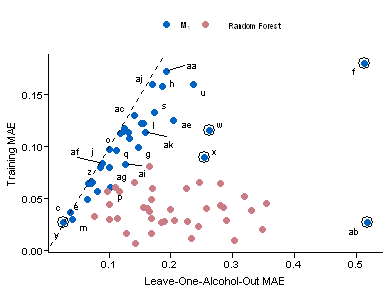

In [53]:
options(repr.plot.width = 3.24, repr.plot.height = 2.43)
to_plt <- ret_mixed %>%
       rownames_to_column("a") %>%
       left_join(da, by = "a") %>%
       mutate(type = factor(ifelse(order == "tertiary", "tertiary",
              ifelse(allylic == 1 | homoallylic == 1, "allylic", "none"))))

  

ggplot(to_plt,
       aes(x = MAE.loogam, y = MAE.traingam)) +
       geom_point(aes(color = "m"), alpha = 1) +
       geom_point(aes(x = MAE.loorf, y = MAE.trainrf,
                      color = "rf"), alpha = 1) +
       geom_text_repel(aes(label = gsub("1", "", a)),
                       size = 2, max.overlaps = 12) +
       geom_abline(intercept = 0, slope = 1, linetype = 2) +

       geom_point(data = to_plt %>% filter(type != "none"),
                  aes(x = MAE.loogam, y = MAE.traingam),
              pch = 1, size = 3, show.legend = F) +

       labs(x = "Leave-One-Alcohol-Out MAE", y = "Training MAE") +
       scale_color_manual(values = agd_palette[c(1, 3)],
                          labels = c(expression(M[1]),
       "Random Forest")) +
       theme_prism(base_size = 6.3)  +
       theme(text = element_text(face = "plain", family = "sans")) +
       theme(legend.position = "top")

ggsave("../doexyF_paper/plots/loo.svg", width = 3.24, height = 2.43)
ggsave("../doexyF_paper/plots/loo.png", width = 3.24, height = 2.43, dpi = 600)

## Out-of-sample validation
Predictions with uncertainty on the new set of alcohols.

In [54]:
va_fact <- read.csv("../data/Deoxyfluorination_validation_alcohols.csv")
va_yields <- read.csv("../data/Deoxyfluorination_validation_data.csv")

va_fact <- va_fact %>% select(-colnames(va_fact)[1]) %>% rename(a = name)
va_desc <- va_fact %>%
    left_join(da_dft, by = "a") %>%
    mutate(C_PVBur = ifelse(a == "1am", 0.425, C_PVBur))

va_yield <- va_yields %>%
    filter(ignore == 0) %>%
    rename(s = so2f, b = base, a = name) %>%
    select(a, b, s, yield, yield_THF) %>%
    group_by(a, b, s) %>%
    summarize(yield_tot = mean(yield + yield_THF),
              yield = mean(yield)) %>%
    ungroup()

va <- va_yield %>% left_join(va_desc, by = "a")

`summarise()` has grouped output by 'a', 'b'. You can override using the
`.groups` argument.


In [55]:
va_yields %>% dim()

[1] 116  11

Analysis  of the alcohol-base interaction in the validation set.

In [56]:
mv <- lm(yield ~ (a + b + s)^2, data = va_yield)

# compute interaction effects with trt.vs.ctrl contrast
abv <- emmeans(mv, trt.vs.ctrl ~ b | a, ref = "BTPP")
asv <- emmeans(mv, trt.vs.ctrl ~ s | a, ref = "PBSF")

abv_ctr <- as.data.frame(abv$contrast) %>%
    mutate(contrast = as.factor(gsub(" - BTPP", "", contrast)))

asv_ctr <- as.data.frame(asv$contrast) %>%
    mutate(contrast = as.factor(gsub(" - PBSF", "", contrast)))

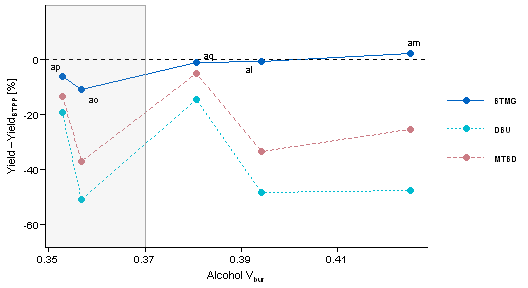

In [57]:
options(repr.plot.width = 4.4, repr.plot.height = 2.4)

to_plt <- abv_ctr %>%
    left_join(va_desc, by = "a") %>%
    filter(benzylic == 1)

pv1 <- ggplot(to_plt, aes(x = C_PVBur, y = estimate, ymax = (estimate + 2 * SE),
           ymin = (estimate - 2 * SE), color = contrast)) +


geom_line(aes(linetype = contrast)) +
geom_hline(yintercept = 0, linetype = 2) +
geom_point() +

geom_text_repel(data = to_plt %>% filter(contrast == "BTMG"),
                aes(label = gsub("1", "", a)), size = 2, color = "black") +

geom_rect(data = data.frame(C_PVBur = 0.36,
     estimate = 0, SE = 0),
     xmin = -Inf, xmax = 0.37,
     ymin = -Inf, ymax = Inf, alpha = 0.1,
     fill = agd_palette[7], color = agd_palette[7]) +


    labs(x = expression(paste("Alcohol", " ", V[bur])),
        y = expression(paste(Yield - Yield[BTPP], " [%]")),
        color = "Base", linetype = "Base") +
    theme_prism(base_size = 6.3) +
    scale_color_manual(values = agd_palette) +
    theme(text = element_text(face = "plain", family = "sans")) +
    guides(color = guide_legend(keywidth = unit(1.9, "line")))

pv1

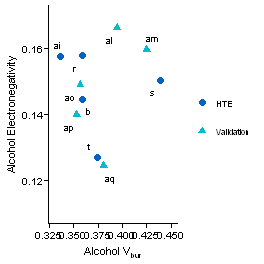

In [58]:
options(repr.plot.width = 2.2, repr.plot.height = 2.2)

pv3 <- va_desc %>%
    filter(order == "primary", !a %in% c("1am2", "1ar")) %>%
    select(a, C_PVBur, C_angle, electronegativity) %>%
    mutate(set = "Validation") %>%
    rbind(da %>%
        filter(order == "primary", benzylic == 1) %>%
        select(a, C_PVBur, C_angle, electronegativity) %>%
        mutate(set = "HTE")) %>%
    mutate(a = reorder(gsub("1", "",a), C_PVBur)) %>%

ggplot(aes(y = electronegativity, x = C_PVBur)) +
    geom_point(aes(shape = set, color = set, group = set)) +

    geom_text_repel(aes(label = a), size = 2) +

    coord_cartesian(ylim = c(0.11, 0.17), xlim = c(0.33, 0.45)) +
    labs(x = expression(paste("Alcohol", " ", V[bur])),
         y = "Alcohol Electronegativity") +
    theme_prism(base_size = 6.3) +
    scale_color_manual(values = agd_palette) +
    theme(text = element_text(face = "plain", family = "sans"))

pv3

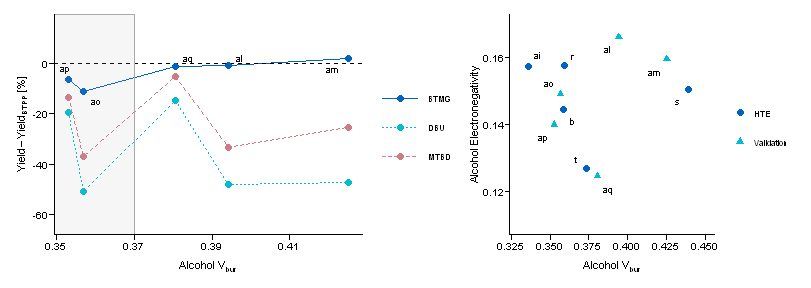

In [59]:
options(repr.plot.width = 6.76, repr.plot.height = 2.4)

pv_c <- (pv1 + pv3) + plot_layout(widths = c(3, 2))
pv_c

ggsave("../doexyF_paper/plots/validation_C.svg", width = 6.76, height = 2.4)
ggsave("../doexyF_paper/plots/validation_C.png", width = 6.76, height = 2.4, dpi = 600)

Make predictions on all validation alcohols and compare models.

In [60]:
preds_gam <- predict(ma, newdata = va %>% model_features(),
                     se.fit = TRUE, type = "response")

In [62]:
# prepare data for random forest evaluation
xval <- va %>% select(-colnames(va)[1], -yield, - yield_tot, -a, -C_VBur)

# trick to align column classes
xval <- rbind(X[1,], xval)[-1,]

xval.num <- xval %>% dplyr::select_if(is.numeric)
xval.fact <- xval %>% dplyr::select_if(is.factor)

#xval.fact.onehot <- mltools::one_hot(xval.fact)
xval.fact.dummy <- fastDummies::dummy_cols(xval.fact, remove_selected_columns = T, remove_first_dummy = T)

#xval.onehot <- cbind(xval.fact.onehot, xval.num)
xval.dummy <- cbind(xval.fact.dummy, xval.num)

In [63]:

preds_rf <- predict(mb1, newdata = xval.dummy)
preds_lasso <- predict(mb2, newdata = xval.dummy)
preds_step <- predict(mb3, newdata = xval.dummy)

In [64]:
val_pred <- cbind(as.data.frame(preds_gam), preds_rf, preds_lasso, preds_step, va) %>%
    mutate(M1 = 100 * pmax(0, fit),
           M1_low = 100 * (fit - 2 * se.fit),
           M1_high = 100 * (fit + 2 * se.fit),
           rf = 100 * preds_rf,
           lasso = 100 * preds_lasso,
           step = 100 * preds_step) %>%
    select(M1, M1_low, M1_high, rf, lasso, step, yield, yield_tot, a, b, s) %>%
    mutate(a = ifelse(a == "1am2", "1am", a)) %>%
    mutate(a = as.factor(a), b = as.factor(b), s = as.factor(s))

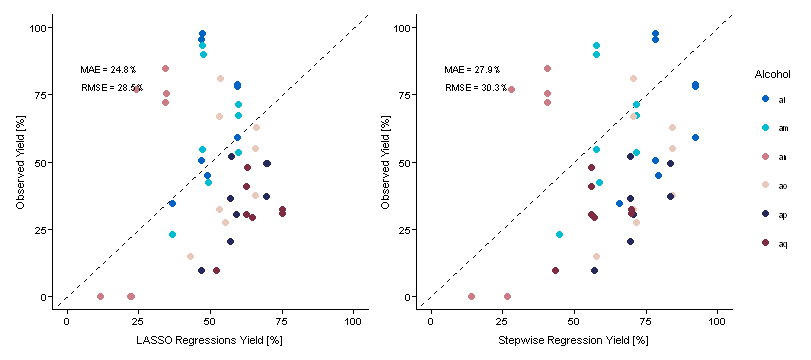

In [65]:
options(repr.plot.width = 3.38, repr.plot.height = 2.6)

pv6 <- ggplot(val_pred, aes(x = lasso, y = yield_tot)) +
     geom_abline(slope = 1, intercept = 0, linetype = 2) +
     geom_point(aes(color = gsub("1", "", a))) +
     labs(color = "Alcohol", y = "Observed Yield [%]",
          #x = expression(paste(M[1], " Yield [%]"))
          x = "LASSO Regressions Yield [%]"
          ) +

     scale_color_manual(values = agd_palette) +
     scale_shape_manual(values = c(1, 16)) +
     theme_prism(base_size = 6.3) +
     xlim(c(0, 100)) + ylim(c(0, 100)) +
     #geom_text(aes(x = 5, y = 85, label = "MAE = 13.4%"),
     #          size = 2, hjust = 0) +
     #geom_text(aes(x = 5, y = 78, label = "RMSE = 16.6%"),
     #          size = 2, hjust = 0) +
     geom_text(aes(x = 5, y = 85, label = "MAE = 24.8%"),
               size = 2, hjust = 0) +
     geom_text(aes(x = 5, y = 78, label = "RMSE = 28.5%"),
               size = 2, hjust = 0) +
     theme(text = element_text(face = "plain", family = "sans"),
           legend.title = element_text()) +
     guides(colour = guide_legend(ncol = 1))

pv7 <- ggplot(val_pred, aes(x = step, y = yield_tot)) +
     geom_abline(slope = 1, intercept = 0, linetype = 2) +
     geom_point(aes(color = gsub("1", "", a))) +

     labs(y = "Observed Yield [%]",
      #x = "Random Forest Yield [%]",
      x = "Stepwise Regression Yield [%]",
          color = "Alcohol") +
     scale_color_manual(values = agd_palette) +
     scale_shape_manual(values = c(1, 16)) +

     theme_prism(base_size = 6.3) +
     guides(colour = guide_legend(ncol = 1)) +
     theme(text = element_text(face = "plain", family = "sans"),
           legend.title = element_text()) +
     xlim(c(0, 100)) + ylim(c(0, 100)) +

     #geom_text(aes(x = 5, y = 85, label = "MAE = 18.1%"), size = 2, hjust = 0) +
     #geom_text(aes(x = 5, y = 78, label = "RMSE = 21.2%"), size = 2, hjust = 0)
     geom_text(aes(x = 5, y = 85, label = "MAE = 27.9%"), size = 2, hjust = 0) +
     geom_text(aes(x = 5, y = 78, label = "RMSE = 30.3%"), size = 2, hjust = 0)

options(repr.plot.width = 6.76, repr.plot.height = 3)
pv6 + pv7 + plot_layout(guides = "collect") 

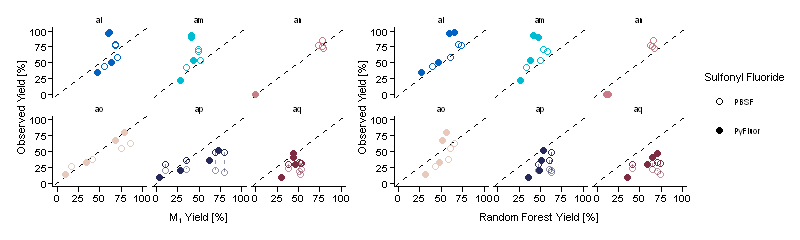

In [66]:
options(repr.plot.width = 6.67, repr.plot.height = 2)

pv4 <- ggplot(val_pred, aes(x = M1, y = yield_tot)) +

     geom_abline(slope = 1, intercept = 0, linetype = 2) +
     geom_point(aes(shape = s, color =  gsub("1", "", a))) +
     geom_point(data = val_pred %>% filter(a %in% c("1ap", "1aq")),
     aes(y = yield, shape = s, color =  gsub("1", "", a)), alpha = 0.5) +

     geom_segment(data = val_pred %>% filter(a %in% c("1ap", "1aq")),
     arrow = arrow(length = unit(0., "cm")), aes(yend = yield, xend = M1,
     color =  gsub("1", "", a)), linetype = 2, size = 0.3, alpha = 0.5) +

     scale_color_manual(values = agd_palette) +
     scale_shape_manual(values = c(1, 16)) +
     labs(y = "Observed Yield [%]",
          x = expression(paste(M[1], " Yield [%]")),
          shape = "Sulfonyl Fluoride", color = "Alcohol") +
     theme_prism(base_size = 6.3) +
     theme(text = element_text(face = "plain", family = "sans"),
           legend.title = element_text()) +
     xlim(c(0, 100)) + ylim(c(0, 100)) +
     facet_wrap(. ~ gsub("1", "", a), nrow = 2) +
     guides(colour = "none")

pv5 <- ggplot(val_pred, aes(x = rf, y = yield_tot)) +
     geom_abline(slope = 1, intercept = 0, linetype = 2) +
     geom_point(aes(shape = s, color =  gsub("1", "", a))) +
     geom_point(data = val_pred %>% filter(a %in% c("1ap", "1aq")),
     aes(y = yield, shape = s, color =  gsub("1", "", a)), alpha = 0.5) +

     geom_segment(data = val_pred %>% filter(a %in% c("1ap", "1aq")),
     arrow = arrow(length = unit(0., "cm")), aes(yend = yield, xend = rf,
     color =  gsub("1", "", a)), linetype = 2, size = 0.3, alpha = 0.5) +

     scale_color_manual(values = agd_palette) +
     scale_shape_manual(values = c(1, 16)) +
     labs(y = "Observed Yield [%]", x = "Random Forest Yield [%]",
          shape = "Sulfonyl Fluoride", color = "Alcohol") +
     theme_prism(base_size = 6.3) +
     theme(text = element_text(face = "plain", family = "sans"),
           legend.title = element_text()) +
     xlim(c(0, 100)) + ylim(c(0, 100)) +

     facet_wrap(. ~ gsub("1", "", a), nrow = 2) +
     guides(color = "none")

pv4 + pv5 + plot_layout(guides = "collect")

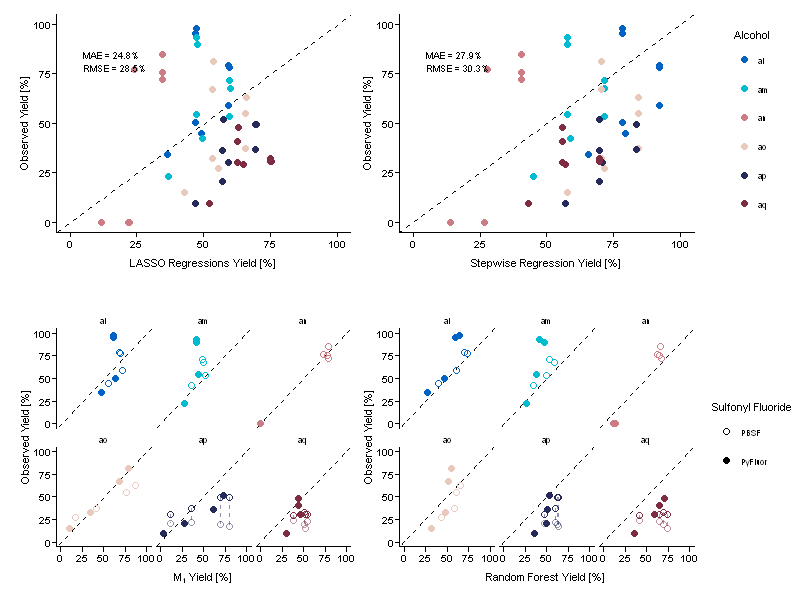

In [67]:
# Make final plot for the paper
options(repr.plot.width = 6.76, repr.plot.height = 5)

pv_ab <- ((pv6 + pv7 + plot_layout(guides = "collect")) /
         plot_spacer() / (pv4 + pv5 + plot_layout(guides = "collect"))
         + plot_layout(heights = c(12, 1, 12)))
pv_ab

ggsave("../doexyF_paper/plots/validation_AB.svg", width = 6.76, height = 5)
ggsave("../doexyF_paper/plots/validation_AB.png", width = 6.76, height = 5, dpi = 600)

In [68]:
val_pred %>% group_by(a) %>%
summarize(
    RMSE.M1 = sqrt(mean((M1 - yield_tot)**2)),
    RMSE.rf = sqrt(mean((rf - yield_tot)**2)),
    RMSE.lasso = sqrt(mean((lasso - yield_tot)**2)),
    RMSE.step = sqrt(mean((step - yield_tot)**2)),
    MAE.M1 = mean(abs(M1 - yield_tot)),
    MAE.rf = mean(abs(rf - yield_tot)),
    MAE.lasso = mean(abs(lasso - yield_tot)),
    MAE.step = mean(abs(step - yield_tot)),
) %>%
    select(-a) %>%
    colMeans() %>%
    as.data.frame() %>%
    round(2) %>%
    rownames_to_column("metric") %>%
    tidyr::separate(metric, into = c("metric", "algorithm"), "\\.") %>%
    rename(value = ".") %>%
    pivot_wider(names_from="metric", values_from="value") %>%
    as.matrix()

algorithm,RMSE,MAE
M1,16.51,13.35
rf,20.26,17.36
lasso,28.49,24.74
step,30.25,27.88


In [69]:
# Compute aggregate statistics in the validation set
val_pred %>%
    group_by(a) %>%
    summarize(
    rmse.rf = sqrt(mean((rf - yield)**2)),
    rmse.M1 = sqrt(mean((M1 - yield)**2)),
    mae.rf = mean(abs(rf - yield)),
    mae.M1 = mean(abs(M1 - yield)),
    mae.rf_tot = mean(abs(rf - yield_tot)),
    mae.M1_tot = mean(abs(M1 - yield_tot)),
    rmse.rf_tot = sqrt(mean((rf - yield_tot)**2)),
    rmse.M1_tot = sqrt(mean((M1 - yield_tot)**2))
) %>%
    select(-a) %>%
    colMeans() %>%
    as.data.frame() %>%
    round(2)

,.
,<dbl>
rmse.rf,23.31
rmse.M1,19.58
mae.rf,19.67
mae.M1,15.27
mae.rf_tot,17.36
mae.M1_tot,13.35
rmse.rf_tot,20.26
rmse.M1_tot,16.51
